In [ ]:
import numpy as np
import os
from sklearn.datasets import fetch_openml
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.linear_model import Lasso, orthogonal_mp
from sklearn.preprocessing import StandardScaler

# Create output directory for figures
if not os.path.exists('./fig'):
    os.makedirs('./fig')

# Load MNIST dataset
print("Loading MNIST dataset...")
mnist = fetch_openml('mnist_784', as_frame=False)
X = mnist['data'].astype(float)
y = mnist['target'].astype(int)
print(f"Dataset loaded: {X.shape[0]} samples with {X.shape[1]} features each")

Loading MNIST dataset...
Dataset loaded: 70000 samples with 784 features each


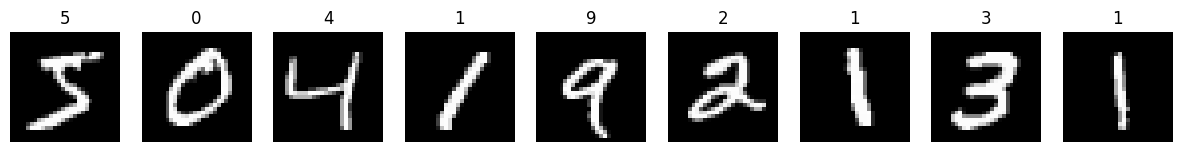

In [ ]:
fig=plt.figure(figsize=(15,3))
fig.patch.set_facecolor('white')
for i in range(9):
  plt.subplot(191+i)
  plt.imshow(X[i].reshape(28,28),'gray')
  plt.title(y[i])
  plt.axis('off')

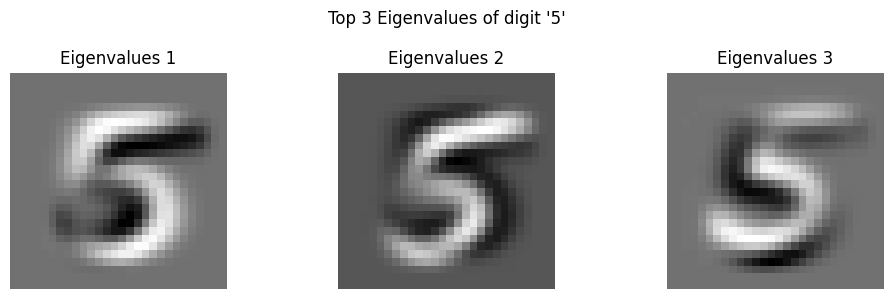

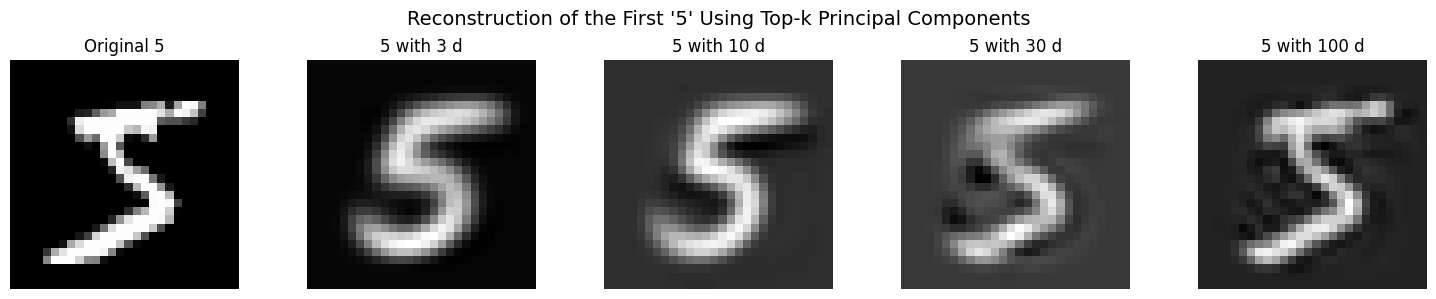

In [ ]:
#Q1. Extract all the ‘’5’’ images (6313 vectors). Use centered PCA (5’s center) to decompose.

# Filter all images with label 5

X_5 = X[y == 5]

# Centering: subtracting the mean of all '5's

mean_5 = np.mean(X_5, axis=0)
X_5_centered = X_5 - mean_5

# Decompose all "5s" using PCA

pca = PCA()
pca.fit(X_5_centered)

# (a) Show the eigenvectors with the three largest eigenvalues

fig = plt.figure(figsize=(10, 3))
for i in range(3):
    plt.subplot(1, 3, i + 1)
    plt.imshow(pca.components_[i].reshape(28, 28), cmap='gray')
    plt.title(f"Eigenvalues {i+1}")
    plt.axis('off')
plt.suptitle("Top 3 Eigenvalues of digit '5'")
plt.tight_layout()
plt.savefig('./fig/Q1a_top3_eigenvalues.png')
plt.show()

# (b) Use the top {3,10,30,100} eigenvectors to reconstruct the first "5" image,

original = X_5[0]

# Post-centered image (for PCA reconstruction)

x0 = X_5_centered[0]
ks = [3, 10, 30, 100]

fig, axes = plt.subplots(1, len(ks) + 1, figsize=(15, 3))
fig.patch.set_facecolor('white')

axes[0].imshow(original.reshape(28, 28), cmap='gray')
axes[0].set_title("Original 5")
axes[0].axis('off')


for i, k in enumerate(ks):

    # transform takes the projection coefficients of the first k principal components.

    coeffs = pca.transform([x0])[:, :k]

    # Reconstruction formula: the projection coefficient is converted back to the original space and then added back to the mean value deducted during centering.

    recon = mean_5 + coeffs @ pca.components_[:k]
    axes[i+1].imshow(recon.reshape(28, 28), cmap='gray')
    axes[i+1].set_title(f"5 with {k} d")
    axes[i+1].axis('off')

plt.suptitle("Reconstruction of the First '5' Using Top-k Principal Components", fontsize=14)
plt.tight_layout()
plt.savefig('./fig/Q1b_reconstruction_with_original.png')
plt.show()

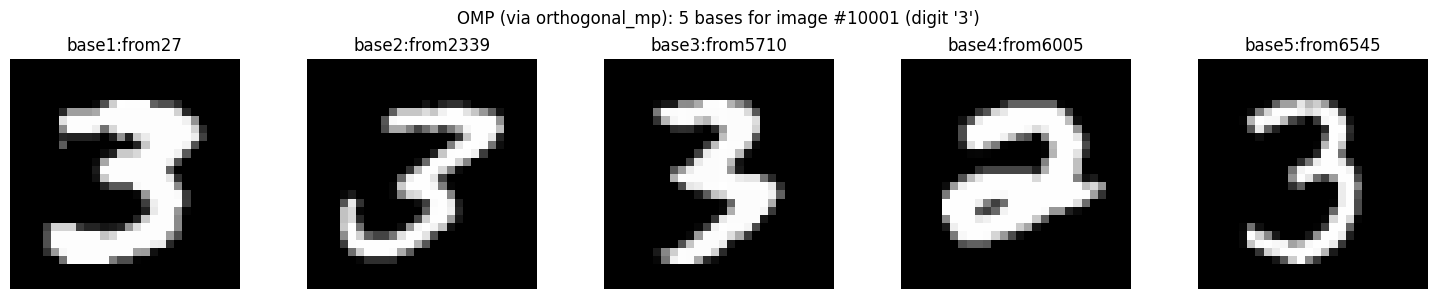

In [ ]:
#Q2. Define the first 10,000 images as the training set. Use OMP from sklearn to answer the following questions.

# Training set: the first 10,000 images as a dictionary

train = X[:10000]  # (10000, 784)
D = train.T        # The shape of dictionary D is (784, 10000)

#(a) Find the 5 bases of the #10001 image (‘’3’’) with sparsity=5. Show the 5 bases.

target_10001 = X[10000]  # 第 10001 張圖像

# Use orthogonal_mp to solve the sparse representation by entering the dictionary D and the target vector.
# Set the parameter n_nonzero_coefs to 5.

coef_10001 = orthogonal_mp(D, target_10001, n_nonzero_coefs=5)
selected_indices = np.flatnonzero(coef_10001)

# Display these 5 basis, directly from the training set

fig, axes = plt.subplots(1, 5, figsize=(15, 3))
for i, idx in enumerate(selected_indices, start=1):
    axes[i-1].imshow(train[idx].reshape(28, 28), cmap='gray')
    axes[i-1].set_title(f"base{i}:from{idx}")
    axes[i-1].axis('off')
plt.suptitle("OMP (via orthogonal_mp): 5 bases for image #10001 (digit '3')")
plt.tight_layout()
plt.savefig('./fig/Q2a_5_bases.png')
plt.show()

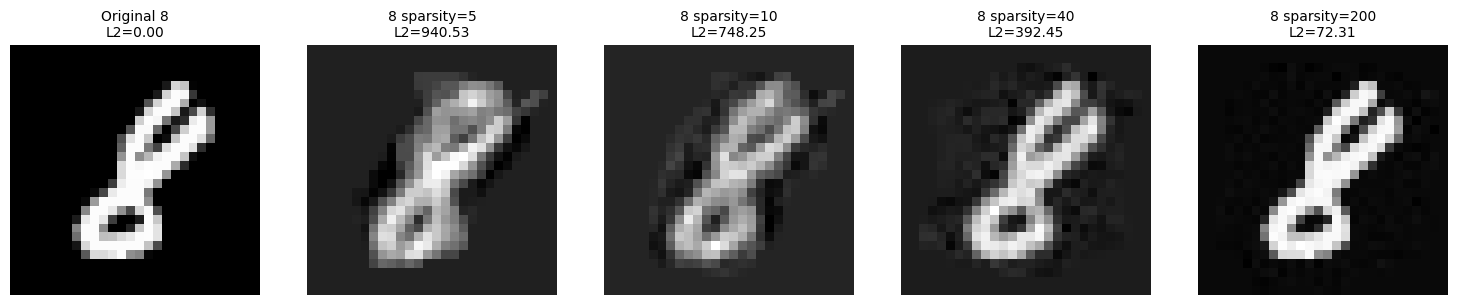

In [ ]:
#(b) Find the bases of the #10002 image (‘’8’’) with sparsity={5,10,40,200}. Show the reconstruction images and calculate their reconstruction errors using L-2 norm (Euclidean distance)

target_10002 = X[10001]
sparsities = [5, 10, 40, 200]
recon_imgs = []
recon_errors = []

for sp in sparsities:
    # use orthogonal_mp
    coef = orthogonal_mp(D, target_10002, n_nonzero_coefs=sp)

    # Obtain a reconstructed image
    reconstruction = D.dot(coef)

    # Calculation L2 Error
    error = np.linalg.norm(target_10002 - reconstruction)

    # results
    recon_imgs.append(reconstruction)
    recon_errors.append(error)

num_cols = len(sparsities) + 1
fig, axes = plt.subplots(1, num_cols, figsize=(15, 3))
fig.patch.set_facecolor('white')

axes[0].imshow(target_10002.reshape(28, 28), cmap='gray')
axes[0].set_title("Original 8\nL2=0.00", fontsize=10)
axes[0].axis('off')

for i, sp in enumerate(sparsities):
    axes[i+1].imshow(recon_imgs[i].reshape(28, 28), cmap='gray')
    axes[i+1].set_title(f"8 sparsity={sp}\nL2={recon_errors[i]:.2f}", fontsize=10)
    axes[i+1].set_xlabel(f"L2={recon_errors[i]:.2f}", fontsize=10)
    axes[i+1].axis('off')

plt.tight_layout()
plt.savefig('./fig/Q2b_compare.png')
plt.show()



Number of '8' images: 6825


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.055e+04, tolerance: 1.088e+03
  model = cd_fast.enet_coordinate_descent(


Alpha: 0.01, nnz: 229, L2 error: 233.67


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.143e+03, tolerance: 1.088e+03
  model = cd_fast.enet_coordinate_descent(


Alpha: 0.001, nnz: 442, L2 error: 43.53


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.516e+03, tolerance: 1.088e+03
  model = cd_fast.enet_coordinate_descent(


Alpha: 0.0001, nnz: 958, L2 error: 6.37


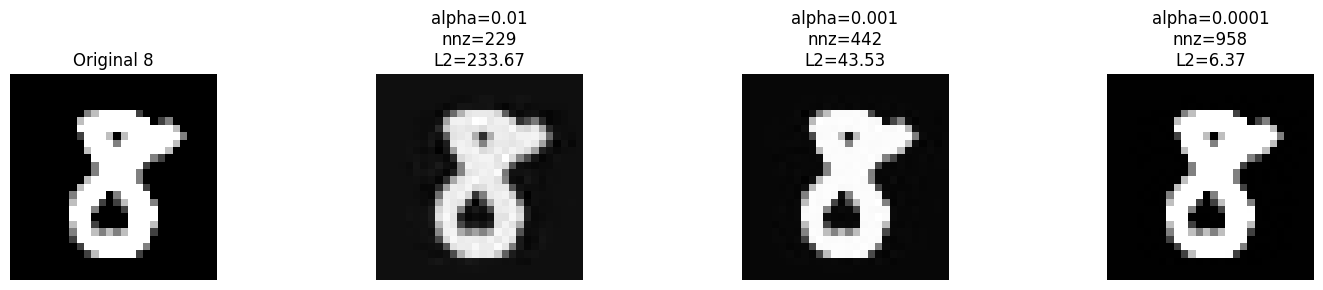

'Conclusion:\nWe use the Lasso model to perform sparse reconstruction of "8" images in MNIST, and observe the reconstruction performance under different α (regularization strength).\nThe experimental results show that as α decreases, the L1 penalty becomes weaker, the model tends to use more substrates to restore the image, the number of non-zero coefficients (nnz) increases significantly, the reconstruction results are closer to the original image, and the L2 error decreases significantly.\nWhen α = 0.01, the model uses only 229 substrates, and the reconstruction error is as high as 233.67, which makes the image blurrier. When α is reduced to 0.0001, and 958 substrates are used, the L2 error decreases to 6.37, and the details of the image are well restored.\nThis result demonstrates Lasso\'s weighing mechanism between "sparsity" and "reconstruction accuracy".\nAccording to the observation, α in the range of 0.001 to 0.0001 is a better choice for this experiment because it can take car

In [ ]:
#Q3. Extract all the ‘’8’’ images (6825 vectors). Use LASSO from sklearn to answer the following questions.

# Data Preparation, Extract all "8s" in MNIST
X_8 = X[y == 8]
print("Number of '8' images:", X_8.shape[0])

#(a) Use the first 6824 images as the base set and then then reconstruct the last ‘’8’’ using LASSO.
# Let 𝛼 = {0.01,0.001,0.0001} be the constant that multiplies the L1 term, show number of nonzero coefficients corresponding to each 𝛼 and the ℓ reconstruction error.


# Previously 6824 as dictionary base, last one as target
base_8 = X_8[:6824]
target_8 = X_8[6824]
# Dictionary Transpose: one base per column
D = base_8.T
# Unit norm for each column of D
for j in range(D.shape[1]):
    col_norm = np.linalg.norm(D[:, j])
    if col_norm > 1e-12:
        D[:, j] /= col_norm
#(2)Lasso for 3 alpha values
alpha_list = [0.01, 0.001, 0.0001]
lasso_results = {}
for alpha in alpha_list:

    # fit_intercept=False Indicates no learning of bias/intercept (since we have already used 6824 images as a base to explain target)
    model = Lasso(alpha=alpha, fit_intercept=False, max_iter=5000)
    model.fit(D, target_8)

    c = model.coef_
    nnz = np.sum(np.abs(c) > 1e-6)
    reconstruction = D.dot(c)
    error = np.linalg.norm(target_8 - reconstruction)  # L2 norm

    lasso_results[alpha] = {"nnz": nnz,
                 "error": error,
                 "reconstruction": reconstruction}
    print(f"Alpha: {alpha}, nnz: {nnz}, L2 error: {error:.2f}")

#(3)Original + each alpha reconstruction
num_cols = len(alpha_list) + 1
fig,axes = plt.subplots(1, num_cols, figsize=(15, 3))
axes[0].imshow(target_8.reshape(28,28), cmap='gray')
axes[0].set_title("Original 8")
axes[0].axis('off')

for i, alpha in enumerate(alpha_list):
    ax = axes[i+1]
    rec_img = lasso_results[alpha]["reconstruction"]
    err = lasso_results[alpha]["error"]
    nnz = lasso_results[alpha]["nnz"]
    ax.imshow(rec_img.reshape(28,28), cmap='gray')
    ax.set_title(f"alpha={alpha}\nnnz={nnz}\nL2={err:.2f}")
    ax.axis('off')

plt.tight_layout()
plt.show()

# ==== ==== ==== ==== ==== ==== ==== ==== ===== ==== ==== ==== ==== ==== ==== ==== ====
"""Conclusion:
We use the Lasso model to perform sparse reconstruction of "8" images in MNIST, and observe the reconstruction performance under different α (regularization strength).
The experimental results show that as α decreases, the L1 penalty becomes weaker, the model tends to use more substrates to restore the image, the number of non-zero coefficients (nnz) increases significantly, the reconstruction results are closer to the original image, and the L2 error decreases significantly.
When α = 0.01, the model uses only 229 substrates, and the reconstruction error is as high as 233.67, which makes the image blurrier. When α is reduced to 0.0001, and 958 substrates are used, the L2 error decreases to 6.37, and the details of the image are well restored.
This result demonstrates Lasso's weighing mechanism between "sparsity" and "reconstruction accuracy".
According to the observation, α in the range of 0.001 to 0.0001 is a better choice for this experiment because it can take care of both the compression effect and the reconstruction quality.
In addition, since the model is more difficult to converge at small α values, sklearn may show ConvergenceWarning warnings, which is a predictable behavior."""


Q3(b) - Coordinate Descent Lasso
Nonzero Coefficients: 442
L2 Reconstruction Error: 43.5294


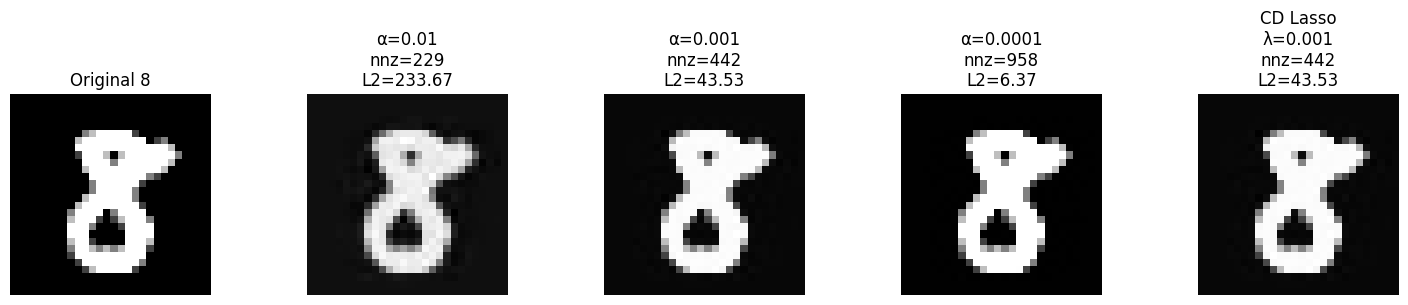

In [ ]:
# Q3(b)Handcraft the Lasso using coordinate descent

# Soft-thresholding：Let the solution be sparse (push small coefficients to 0)
# (rho, λ) = sign(rho) * max(|rho| - λ, 0)
def soft_threshold(rho, lam):
    if rho < -lam:
        return rho + lam
    elif rho > lam:
        return rho - lam
    else:
        return 0.0

# Coordinate Descent Lasso
def coordinate_descent_lasso(X, y, lam=0.001, max_iter=5000, tol=1e-6):
    m, n = X.shape
    beta = np.zeros(n)
    residual = y.copy() # initial residual r = y - X @ beta = y
    X_col_norms = np.sum(X**2, axis=0) # Square the L2 norm of each base image.
    lam_eff = lam * m  # To "align the results of sklearn."
    # In order to align the hand-carved Lasso regularization with sklearn's Lasso α，
    # We adjust λ to λ_eff = λ × m because the loss in sklearn is divided by 2n.
    # In this way, both of our model loss functions are consistent in scale and we can compare the results fairly.
    # I've tried not to scaling, lam_eff = lam, Handcraft results in a "less sparse" or significantly different error.
    for it in range(max_iter):
        max_change = 0
        for j in range(n):
            if X_col_norms[j] == 0:
                continue
            rho = X[:, j].dot(residual) + X_col_norms[j] * beta[j]
            new_beta_j = soft_threshold(rho, lam_eff) / X_col_norms[j]
            delta = new_beta_j - beta[j]
            if delta != 0:
                beta[j] = new_beta_j
                residual -= X[:, j] * delta
                max_change = max(max_change, abs(delta))
        if max_change < tol:
            break
    return beta

X = base_8
y = target_8
X = X / np.linalg.norm(X, axis=1, keepdims=True)  # Unitizing each map
X = X.T         # shape: (784, 6824)，Each column is a base image, conforming to the Lasso format.

beta_cd = coordinate_descent_lasso(X, y, lam=0.001) # Reconstruct the image with coefficients
reconstruction_cd = X @ beta_cd
nnz_cd = np.sum(np.abs(beta_cd) > 1e-6) # Calculating non-zero coefficients
error_cd = np.linalg.norm(y - reconstruction_cd) # Calculate the reconstruction error (L2 norm)

"""Compare the result with (a)"""

print("\nQ3(b) - Coordinate Descent Lasso")
print(f"Nonzero Coefficients: {nnz_cd}")
print(f"L2 Reconstruction Error: {error_cd:.4f}")

num_cols = len(alpha_list) + 2
fig, axes = plt.subplots(1, num_cols, figsize=(15, 3))
axes[0].imshow(target_8.reshape(28, 28), cmap='gray')
axes[0].set_title("Original 8")
axes[0].axis('off')

for i, alpha in enumerate(alpha_list):
    ax = axes[i + 1]
    rec_img = lasso_results[alpha]["reconstruction"]
    err = lasso_results[alpha]["error"]
    nnz = lasso_results[alpha]["nnz"]
    ax.imshow(rec_img.reshape(28, 28), cmap='gray')
    ax.set_title(f"α={alpha}\nnnz={nnz}\nL2={err:.2f}")
    ax.axis('off')


axes[-1].imshow(reconstruction_cd.reshape(28, 28), cmap='gray')
axes[-1].set_title(f"CD Lasso\nλ=0.001\nnnz={nnz_cd}\nL2={error_cd:.2f}")
axes[-1].axis('off')

plt.tight_layout()
plt.show()


In [ ]:
# The efficiency of your implementation will be considered
# Runtime Evaluation and Comparison
# Compares the execution time of the Handcraft coordinate descent method with sklearn.Lasso. With λ = 0.001, the results are as follows:
# Lasso time estimation
import time
start = time.time()
model = Lasso(alpha=0.001, fit_intercept=False, max_iter=5000)
model.fit(D, target_8)
end = time.time()
print(f"[Sklearn Lasso] Execution time: {end - start:.4f} s")
# Handcraft Coordinate Descent time estimation
start = time.time()
beta_cd = coordinate_descent_lasso(X, y, lam=0.001)
end = time.time()
print(f"[Coordinate Descent] Execution time: {end - start:.4f} s")

"""Conclusion:
It's on the Internet.
Although the hand-crafted version uses coordinate descent and residual update to speed up the computation, the sklearn implementation is still significantly more efficient than the pure Python implementation because it uses C to compile the backend and performs vectorization and sparse matrix optimization.
However, the hand-engraved version has the advantages of high readability, free control of λ and updating method, and is suitable for example experiments in learning coordinate descent and Lasso sparse regularization."""

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.143e+03, tolerance: 1.088e+03
  model = cd_fast.enet_coordinate_descent(


[Sklearn Lasso] Execution time: 19.7524 s
[Coordinate Descent] Execution time: 123.9705 s


"Conclusion:\nIt's on the Internet.\nAlthough the hand-crafted version uses coordinate descent and residual update to speed up the computation, the sklearn implementation is still significantly more efficient than the pure Python implementation because it uses C to compile the backend and performs vectorization and sparse matrix optimization.\nHowever, the hand-engraved version has the advantages of high readability, free control of λ and updating method, and is suitable for example experiments in learning coordinate descent and Lasso sparse regularization."